In [66]:
import pandas as pd
import psycopg2
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
def redshift_connection():
    try:
        # Establish a connection to the Redshift database
        conn = psycopg2.connect(
            host=os.getenv('REDSHIFT_HOST'),
            port=os.getenv('REDSHIFT_PORT'),
            dbname=os.getenv('REDSHIFT_DB'),
            user=os.getenv('REDSHIFT_USER'),
            password=os.getenv('REDSHIFT_PASSWORD')
        )

        # Create a cursor to execute SQL queries
        print("Connection to Redshift database successful")
        cursor = conn.cursor()

        # SQL query for sequence analysis
        # SQL query for sequence analysis with player_dob included without duplicates
        sql_script = """
        SELECT 
            fixture_mid,
            player_mid,
            SUM(kick_errors) as total_kick_errors,
            sum(rucks_won) as total_rucks_won,
            sum(rucks_lost) as total_rucks_lost,
            SUM(linebreaks) AS total_linebreaks,
            SUM(tries) AS total_tries,
            SUM(supported_break) AS total_supported_breaks,
            SUM(defenders_beaten) AS total_defenders_beaten,
            SUM(jackals_success) AS total_jackals_success,
            SUM(intercepts) AS total_intercepts,
            SUM(tackles_made) AS total_tackles_made,
            SUM(tackles_missed) AS total_tackles_missed,
            SUM(offloads) AS total_offloads,
            SUM(carries) AS total_carries,
            SUM(carry_metres) AS total_carry_metres,
            SUM(carries_dominant) AS total_carries_dominant,
            SUM(turnovers_conceded) AS total_turnovers_conceded,
            SUM(penalties_conceded) AS total_penalties_conceded,
            SUM(carry_metres_post_contact) AS total_carry_metres_post_contact,
            sum(ruck_arrivals_attack_first2) as total_ruck_arrivals_attack_first2,
            sum(ruck_arrivals_defence_first2) as total_ruck_arrivals_defence_first2
        FROM 
            bal.tab_match_player_stats_v2
        WHERE 
            season = 2024
            AND competition = 'Super Rugby Pacific'
        GROUP BY 
            fixture_mid,player_mid
        """

        cursor.execute(sql_script)
        print("Database connection is active.")

        results = cursor.fetchall()

        return results

    except psycopg2.Error as e:
        # Log and re-raise the database connection error
        print(f"Database connection error: {e}")
        raise

    finally:
        # Ensure the database connection is closed
        if conn:
            conn.close()
            print("Redshift connection closed")

def create_redshift_df(results):
    column_names_for_results_df = ['fixture_mid', 'player_mid',
            'kick_errors',
            'rucks_won',
            'rucks_lost',
            'total_linebreaks',
            'total_tries',
            'total_supported_breaks',
            'total_defenders_beaten',
            'total_jackals_success',
            'total_intercepts',
            'total_tackles_made',
            'total_tackles_missed',
            'total_offloads',
            'total_carries',
            'total_carry_metres',
            'total_carries_dominant',
            'total_turnovers_conceded',
            'total_penalties_conceded', 
            'total_carry_metres_post_contact',
            'ruck_arrivals_attack_first2',
            'ruck_arrivals_defence_first2']
    df_redshift_data = pd.DataFrame(results, columns=column_names_for_results_df)
    return df_redshift_data

In [68]:
results = redshift_connection()
df_redshift_data_all_by_fixture = create_redshift_df(results)

Connection to Redshift database successful
Database connection is active.
Redshift connection closed


In [69]:
df_redshift_data_all_by_fixture.shape

(4048, 22)

In [70]:
df_redshift_data_all_by_fixture.to_csv('redshift_data_all_by_fixture.csv', index=False)

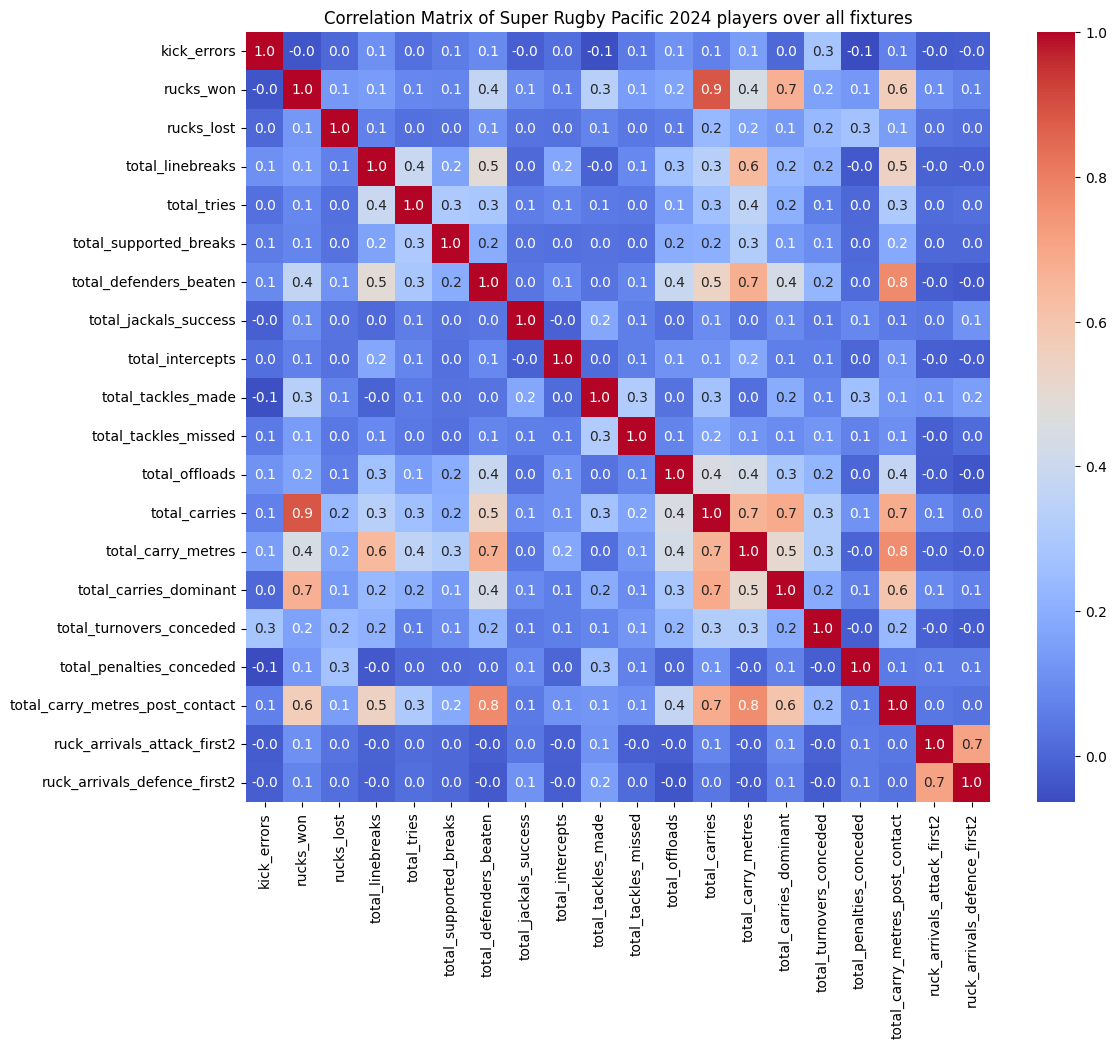

In [73]:
df_redshift_data_all_fixture_dropped = df_redshift_data_all_by_fixture.drop(columns=['fixture_mid','player_mid'])

# Compute the correlation matrix
correlation_matrix = df_redshift_data_all_fixture_dropped.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation Matrix of Super Rugby Pacific 2024 players over all fixtures")
plt.show()

/Users/eben.opperman/Documents/Projects/match_event_weighting/venv/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/eben.opperman/Documents/Projects/match_event_weighting/venv/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


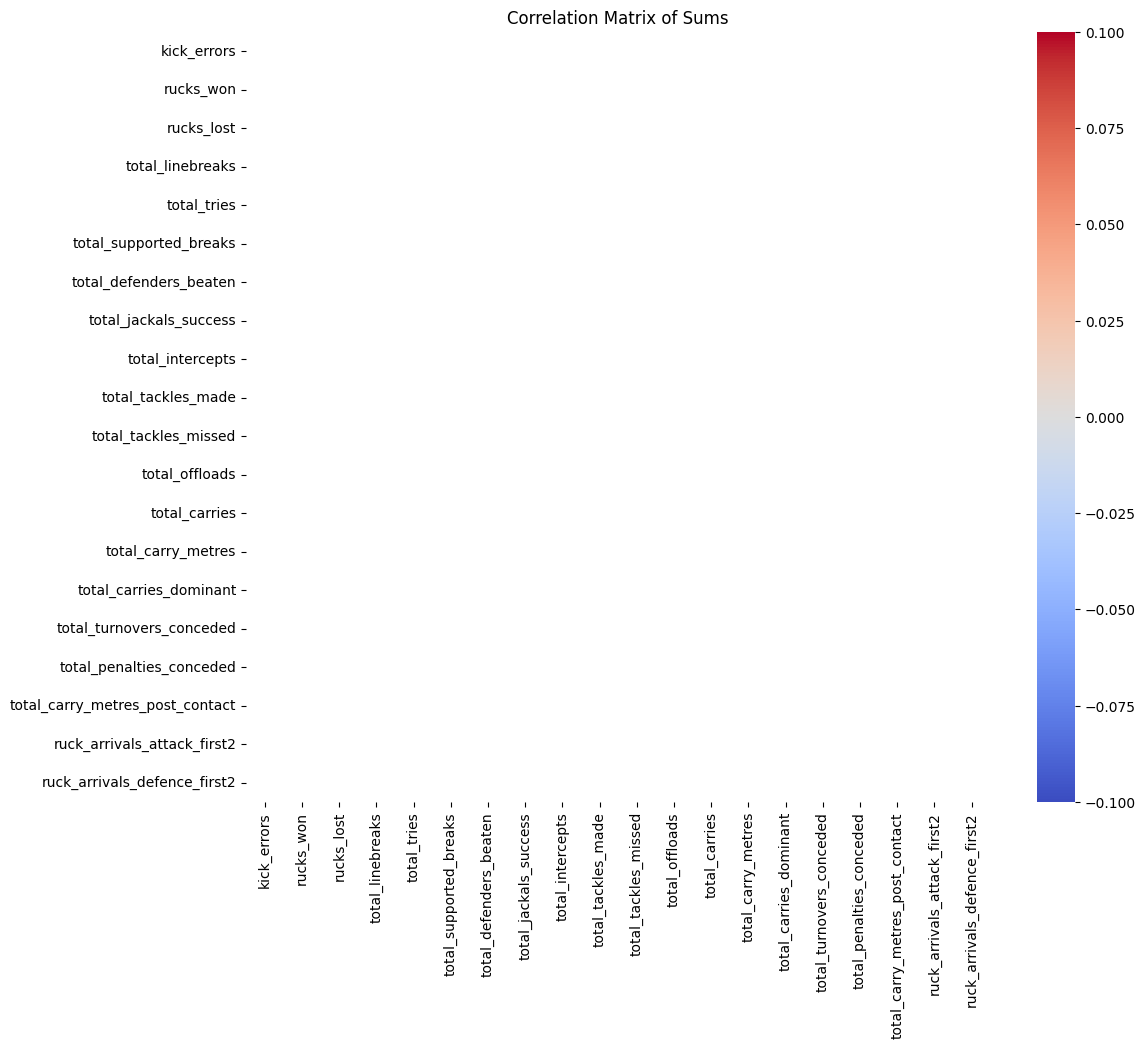

In [ ]:
# Sum each column
sums = df_redshift_data_all_fixture_dropped.sum()

# Convert the sums to a DataFrame
sums_df = pd.DataFrame(sums, columns=['sum']).transpose()

# Since we have only one row, correlation is not meaningful but let's calculate it for the sake of the example
correlation_matrix_2 = sums_df.corr()

# Plot the heatmap (it will be a single value since we have only one row)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Sums")
plt.show()